<a href="https://colab.research.google.com/github/Johnnyyy24/3EMA-Strategy-on-Bitcoin/blob/main/BTCx3EMA_0830.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Inspired by: https://www.youtube.com/watch?v=D80KULtCbHw

## 主要是用EMA來找出 upward/downward trend

## 進而做趨勢型的交易

## 回測看看表現

In [ ]:
!pip install yfinance
import yfinance as yf
BTC = yf.Ticker("BTC-USD")

In [ ]:
price = BTC.history(period='60d',interval='5m')
price.columns = [column.lower() for column in price.columns]
price

,open,high,low,close,volume,dividends,stock splits
Datetime,,,,,,,
2021-07-03 00:00:00+01:00,33735.085938,33735.085938,33687.347656,33689.113281,0,0,0
2021-07-03 00:05:00+01:00,33750.570312,33830.261719,33750.570312,33817.296875,146874368,0,0
2021-07-03 00:10:00+01:00,33800.718750,33859.175781,33800.718750,33837.902344,70406144,0,0
2021-07-03 00:15:00+01:00,33831.777344,33831.777344,33786.898438,33786.898438,0,0,0
2021-07-03 00:20:00+01:00,33752.527344,33753.339844,33732.277344,33732.277344,0,0,0
...,...,...,...,...,...,...,...
2021-08-31 02:30:00+01:00,46955.066406,46972.933594,46955.066406,46958.191406,8306688,0,0
2021-08-31 02:35:00+01:00,46994.613281,46994.613281,46967.562500,46967.562500,5120000,0,0
2021-08-31 02:40:00+01:00,46909.261719,46929.296875,46904.085938,46904.085938,989184,0,0


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
import talib
price['ema25'] = talib.EMA(price['close'], timeperiod=25)
price['ema50'] = talib.EMA(price['close'], timeperiod=50)
price['ema100'] = talib.EMA(price['close'], timeperiod=100)

In [ ]:
price = price.dropna() # 把沒有技術指標的移除

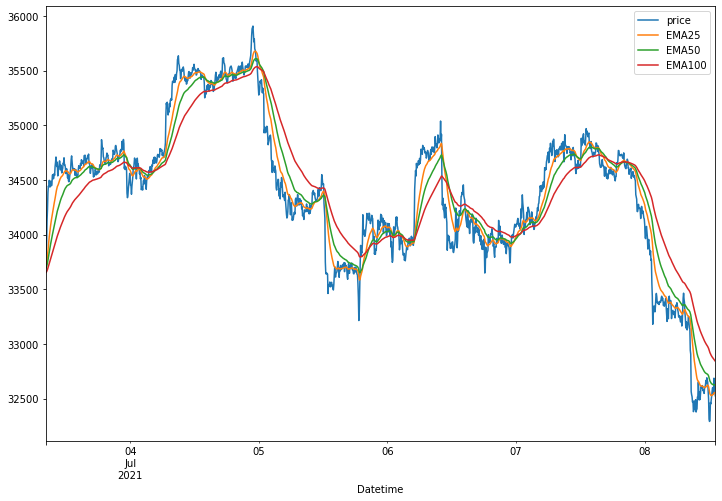

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))

a = price['close'][:1500].plot(label='price')
b = price['ema25'][:1500].plot(label='EMA25')
c = price['ema50'][:1500].plot(label='EMA50')
d = price['ema100'][:1500].plot(label='EMA100')



plt.legend()
plt.show()

定義EMA距離夠寬的意思？
從圖看來大概都相距100點就算夠寬了 先用這個比例當作定義(100/48000)

In [ ]:
buy_orders, sell_orders = [], []
margin = 0.0002
# for index,value in price.iterrows():
ema_ASEC1 = (price['ema25'] - price['ema50'])  > 100
ema_ASEC2 = (price['ema50'] - price['ema100'])  > 100
ema_DSEC1 = (price['ema25'] - price['ema50'])  < (-1 * 100)
ema_DSEC2 = (price['ema50'] - price['ema100'])  < (-1 * 100)

price['trend'] = 0

price.loc[ema_ASEC1 & ema_ASEC2,'trend'] = 1
price.loc[ema_DSEC1 & ema_DSEC2,'trend'] = -1 

price

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,open,high,low,close,volume,dividends,stock splits,ema25,ema50,ema100,trend
Datetime,,,,,,,,,,,
2021-07-03 08:15:00+01:00,33707.953125,33758.695312,33703.394531,33758.695312,0,0,0,33717.983714,33689.153217,33651.042734,0
2021-07-03 08:20:00+01:00,33767.687500,33862.042969,33757.371094,33855.457031,51763200,0,0,33728.558585,33695.674935,33655.090542,0
2021-07-03 08:25:00+01:00,33840.683594,33905.214844,33840.683594,33905.214844,21602304,0,0,33742.147528,33703.892187,33660.043499,0
2021-07-03 08:30:00+01:00,33947.273438,34152.941406,33947.273438,34125.000000,333893632,0,0,33771.597718,33720.406219,33669.250558,0
2021-07-03 08:35:00+01:00,34127.054688,34234.363281,34127.054688,34229.906250,159750144,0,0,33806.852220,33740.386612,33680.352651,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31 02:30:00+01:00,46955.066406,46972.933594,46955.066406,46958.191406,8306688,0,0,47115.903469,47430.950305,47710.985575,-1
2021-08-31 02:35:00+01:00,46994.613281,46994.613281,46967.562500,46967.562500,5120000,0,0,47104.492625,47412.778234,47696.264326,-1
2021-08-31 02:40:00+01:00,46909.261719,46929.296875,46904.085938,46904.085938,989184,0,0,47089.076726,47392.829517,47680.577626,-1


In [ ]:
activate_long,activate_short = False,False
buy_orders, sell_orders = [], []
buy, sell = False, False
can_trade = True
last_trade_trend = 0
pl_ratio = 2 # to be tuned 

def create_orders(side,price,index_time,sl,tp):
    if side == 'buy':
        buy_orders.append({'side':side,'price':price,'time':index_time,'sl':sl,'tp':tp})
    elif side == 'sell':
        sell_orders.append({'side':side,'price':price,'time':index_time,'sl':sl,'tp':tp})

    
# 處理 can_trade, 一個波段就是做一次交易

for index,value in price.iterrows():
    
    if buy:
        create_orders('buy',value['open'],index,value['ema50'],value['open']+(value['open']-value['ema50'])*pl_ratio) 
        buy = False 
        activate_long = False
        print('buy',value['open'],index)
        last_trade_trend = value['trend'] # 紀錄這個波段的趨勢屬性
        continue 
    if sell:
        create_orders('sell',value['open'],index,value['ema50'],value['open']-(value['ema50']-value['open'])*pl_ratio)
        sell = False
        activate_short = False
        print('sell',value['open'],index)
        last_trade_trend = value['trend'] # 紀錄這個波段的趨勢屬性
        continue 

    if activate_long: 
        if value['low'] < value['ema100']: # 跌破ema100, 上升趨勢已經消失，不做這個波段
            activate_long = False
        elif value['high'] > value['ema25']:  # 維持在ema50以上, 直接做多
            buy = True 
            activate_long = False
        continue
    elif activate_short:
        if value['high'] > value['ema100']: # 漲破ema100, 下降趨勢已經消失，不做這個波段
            activate_sell = False
        elif value['low'] < value['ema25']:  # 維持在ema50以下, 直接做空
            sell = True 
            activate_sell = False
        continue        

    if last_trade_trend != value['trend']: # 上次交易的波動和這次不同 才檢視ema, 預設為0所以1,-1都會觸發
        if value['trend'] == 1: # 上升趨勢
            if value['ema25'] >= value['low'] > value['ema100']: # 不能跌破ema100
                activate_long = True
                # print(cnt,index,'回調中，觸發主動做多條件')
                #cnt += 1
        
        elif value['trend'] == -1:
            if value['ema100'] > value['high'] >= value['ema25']: # 不能漲破ema100
                activate_short = True 
                # print(cnt,index,'回調中，觸發主動做空條件')
        else: # trend == 0 沒有明顯趨勢
            activate_long, activate_short = False, False 
    

buy 34581.87890625 2021-07-03 12:10:00+01:00
sell 34307.6328125 2021-07-05 05:50:00+01:00
buy 34838.42578125 2021-07-06 09:25:00+01:00
sell 33413.1484375 2021-07-08 04:50:00+01:00
buy 33521.6484375 2021-07-09 17:30:00+01:00
sell 33555.7109375 2021-07-12 15:10:00+01:00
buy 32792.7734375 2021-07-14 17:00:00+01:00
sell 31719.265625 2021-07-15 13:15:00+01:00
buy 32139.28125 2021-07-16 17:20:00+01:00
sell 31499.1171875 2021-07-17 02:20:00+01:00
buy 32115.78125 2021-07-18 04:50:00+01:00
sell 30736.626953125 2021-07-19 15:55:00+01:00
buy 30753.283203125 2021-07-21 09:20:00+01:00
sell 37395.49609375 2021-07-27 00:10:00+01:00
buy 38339.32421875 2021-07-27 15:35:00+01:00
sell 38876.73046875 2021-07-30 12:10:00+01:00
buy 41878.9140625 2021-07-31 01:50:00+01:00
sell 41143.87890625 2021-08-01 18:15:00+01:00
buy 39373.38671875 2021-08-04 18:10:00+01:00
sell 38175.4609375 2021-08-05 12:20:00+01:00
buy 40657.58984375 2021-08-05 20:55:00+01:00
sell 44221.69921875 2021-08-08 17:25:00+01:00
buy 45373.125

In [ ]:
def get_profit(buy_orders,sell_orders,price):
    # 先把買賣單合併
    orders = buy_orders + sell_orders
    orders = sorted(orders, key=lambda k: k['time']) 
    profit = []
    commission = 0.0005
    win_rate = 0
    for order in orders:
        close = False
        for index,value in price[order['time']:].iterrows():
            if index == order['time']:
                continue
            if order['side'] == 'buy':
                if value['high'] > order['tp']: # 打到止盈
                    print('多單止盈,利潤: {}'.format(order['tp']-order['price']))
                    close = True
                    win_rate += 1
                    profit.append(order['tp']-order['price']-(order['tp']+order['price'])*commission)
                elif value['low'] < order['sl']: # 打到止損
                    print('多單止損,利潤: {}'.format(order['sl']-order['price']))
                    close = True
                    profit.append(order['sl']-order['price']-(order['sl']+order['price'])*commission)
                if close:
                    break
            else: # 'sell'
                if value['low'] < order['tp']: # 打到止盈
                    print('空單止盈,利潤: {}'.format(order['price']-order['tp']))
                    close = True
                    win_rate += 1 
                    profit.append(order['price']-order['tp']-(order['tp']+order['price'])*commission)
                elif value['high'] > order['sl']: # 打到止損
                    print('空單止損,利潤: {}'.format(order['price']-order['sl']))
                    close = True
                    profit.append(order['price']-order['sl']-(order['sl']+order['price'])*commission)
                if close:
                    break

        print('累積報酬: {}'.format(sum(profit)))
    win_rate /= (len(buy_orders) + len(sell_orders))
    return profit, win_rate

In [ ]:
profit, win_rate = get_profit(buy_orders,sell_orders,price)

多單止盈,利潤: 278.9092264644278
累積報酬: 278.9092264644278
空單止損,利潤: -212.3953685578963
累積報酬: 66.51385790653148
多單止損,利潤: -169.9273906918097
累積報酬: -103.41353278527822
空單止盈,利潤: 186.85960482958762
累積報酬: 83.4460720443094
多單止損,利潤: -141.2952962701238
累積報酬: -57.849224225814396
空單止盈,利潤: 229.77069929789286
累積報酬: 171.92147507207847
多單止盈,利潤: 172.5875360383434
累積報酬: 344.50901111042185
空單止損,利潤: -434.3265089350498
累積報酬: -89.81749782462794
多單止損,利潤: -288.26512632917
累積報酬: -378.08262415379795
空單止盈,利潤: 131.67663244668802
累積報酬: -246.40599170710993
多單止損,利潤: -62.215918835932825
累積報酬: -308.62191054304276
空單止損,利潤: -173.73679687908952
累積報酬: -482.3587074221323
多單止盈,利潤: 228.73011800891254
累積報酬: -253.62858941321974
空單止盈,利潤: 951.5650301907735
累積報酬: 697.9364407775538
多單止損,利潤: -294.3234441699751
累積報酬: 403.6129966075787
空單止損,利潤: -178.62271022226196
累積報酬: 224.99028638531672
多單止損,利潤: -572.1554415153078
累積報酬: -347.16515512999104
空單止盈,利潤: 299.7011042827362
累積報酬: -47.46405084725484
多單止盈,利潤: 443.224376147773
累積報酬: 395.760325300518

In [ ]:
win_rate

0.4418604651162791

# 改用 python-binance 可以抓比較久以前的資料

In [ ]:
pip install python-binance

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
from binance.client import Client

api_key = 'enter your api key'
api_secret = 'enter your api secret'
client = Client(api_key, api_secret)

In [ ]:
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_5MINUTE, "1 Apr, 2021", "31 Aug, 2021")

In [ ]:
len(klines)

43637

In [ ]:
# klines contain timestamp(每1個小時) & 開高低收 & 其他相對不重要，把它整理成熟悉的dataframe形式
def price_preprocessing(klines):
  #將klines 整理成只有前五個element
  for i in range(len(klines)):
    klines[i] = klines[i][:5]
  #直接將klines轉成dataframe
  df = pd.DataFrame.from_records(klines,columns=['date','open','high','low','close'],index='date')
  return df
def adjust_price_date(prices,start_time):
  date_list = [start_time]
  cur = start_time
  for i in range(len(prices)-1):
    cur_time = datetime.strptime(cur, '%Y-%m-%d %H:%M:%S')
    cur_time += timedelta(minutes=5)
    #cur_time += timedelta(days = 1)
    cur = cur_time.strftime("%Y-%m-%d %H:%M:%S")
    date_list.append(cur)
  prices.index = date_list
  return prices
def PricesStringToInt(prices): 
  targets = ['open','high','low','close']
  for target in targets:
    prices[target]= pd.to_numeric(prices[target], errors='coerce')
  return prices

In [ ]:
price = price_preprocessing(klines)
price = adjust_price_date(prices,'2021-04-01 08:00:00')
price = PricesStringToInt(prices)
price

,open,high,low,close
2021-04-01 08:00:00,58739.46,59093.00,58720.82,59061.14
2021-04-01 08:05:00,59071.84,59088.95,58977.78,59030.01
2021-04-01 08:10:00,59030.00,59068.05,58965.00,58965.00
2021-04-01 08:15:00,58965.01,59027.09,58852.94,58883.57
2021-04-01 08:20:00,58883.57,59000.00,58862.21,58946.69
...,...,...,...,...
2021-08-30 20:00:00,47313.95,47316.52,47002.99,47014.22
2021-08-30 20:05:00,47009.83,47050.00,46853.00,46929.00
2021-08-30 20:10:00,46929.00,47081.92,46890.00,46984.14
2021-08-30 20:15:00,46980.89,47036.14,46900.00,46982.91


In [ ]:
price['ema25'] = talib.EMA(price['close'], timeperiod=25)
price['ema50'] = talib.EMA(price['close'], timeperiod=50)
price['ema100'] = talib.EMA(price['close'], timeperiod=100)

price = price.dropna() # 把沒有技術指標的移除

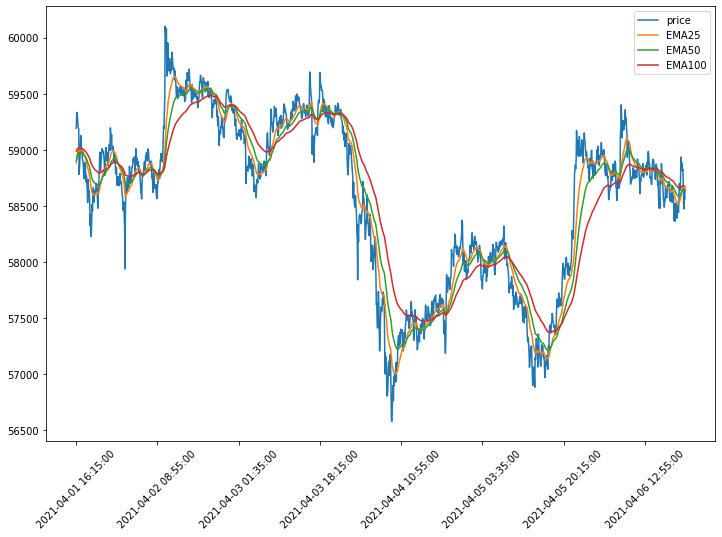

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))

a = price['close'][:1500].plot(label='price')
b = price['ema25'][:1500].plot(label='EMA25')
c = price['ema50'][:1500].plot(label='EMA50')
d = price['ema100'][:1500].plot(label='EMA100')


plt.xticks(rotation = 45)
plt.legend()
plt.show()

In [ ]:
buy_orders, sell_orders = [], []
margin = 0.0002
# for index,value in price.iterrows():
ema_ASEC1 = (price['ema25'] - price['ema50'])  > 100
ema_ASEC2 = (price['ema50'] - price['ema100'])  > 100
ema_DSEC1 = (price['ema25'] - price['ema50'])  < (-1 * 100)
ema_DSEC2 = (price['ema50'] - price['ema100'])  < (-1 * 100)

price['trend'] = 0

price.loc[ema_ASEC1 & ema_ASEC2,'trend'] = 1
price.loc[ema_DSEC1 & ema_DSEC2,'trend'] = -1 

price

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,open,high,low,close,ema25,ema50,ema100,trend
2021-04-01 16:15:00,59050.86,59199.47,58987.29,59192.14,58883.587538,58902.573847,58987.722300,0
2021-04-01 16:20:00,59192.15,59408.48,59180.00,59292.28,58915.025420,58917.856441,58993.753146,0
2021-04-01 16:25:00,59292.29,59490.00,59262.75,59332.85,58947.165772,58934.130699,59000.467935,0
2021-04-01 16:30:00,59332.84,59349.54,59193.19,59294.46,58973.880713,58948.261259,59006.289560,0
2021-04-01 16:35:00,59294.47,59312.00,59169.50,59234.14,58993.900658,58959.472190,59010.801450,0
...,...,...,...,...,...,...,...,...
2021-08-30 20:00:00,47313.95,47316.52,47002.99,47014.22,47668.356487,47918.977553,48036.931661,-1
2021-08-30 20:05:00,47009.83,47050.00,46853.00,46929.00,47611.482911,47880.154904,48014.992421,-1
2021-08-30 20:10:00,46929.00,47081.92,46890.00,46984.14,47563.225764,47845.017064,47994.579501,-1
2021-08-30 20:15:00,46980.89,47036.14,46900.00,46982.91,47518.586090,47811.208944,47974.546442,-1


In [ ]:
activate_long,activate_short = False,False
buy_orders, sell_orders = [], []
buy, sell = False, False
can_trade = True
last_trade_trend = 0
pl_ratio = 2 # to be tuned 

def create_orders(side,price,index_time,sl,tp):
    if side == 'buy':
        buy_orders.append({'side':side,'price':price,'time':index_time,'sl':sl,'tp':tp})
    elif side == 'sell':
        sell_orders.append({'side':side,'price':price,'time':index_time,'sl':sl,'tp':tp})

    
# 處理 can_trade, 一個波段就是做一次交易

for index,value in price.iterrows():
    
    if buy:
        create_orders('buy',value['open'],index,value['ema50'],value['open']+(value['open']-value['ema50'])*pl_ratio) 
        buy = False 
        activate_long = False
        print('buy',value['open'],index)
        last_trade_trend = value['trend'] # 紀錄這個波段的趨勢屬性
        continue 
    if sell:
        create_orders('sell',value['open'],index,value['ema50'],value['open']-(value['ema50']-value['open'])*pl_ratio)
        sell = False
        activate_short = False
        print('sell',value['open'],index)
        last_trade_trend = value['trend'] # 紀錄這個波段的趨勢屬性
        continue 

    if activate_long: 
        if value['low'] < value['ema100']: # 跌破ema100, 上升趨勢已經消失，不做這個波段
            activate_long = False
        elif value['high'] > value['ema25']:  # 維持在ema50以上, 直接做多
            buy = True 
            activate_long = False
        continue
    elif activate_short:
        if value['high'] > value['ema100']: # 漲破ema100, 下降趨勢已經消失，不做這個波段
            activate_sell = False
        elif value['low'] < value['ema25']:  # 維持在ema50以下, 直接做空
            sell = True 
            activate_sell = False
        continue        

    if last_trade_trend != value['trend']: # 上次交易的波動和這次不同 才檢視ema, 預設為0所以1,-1都會觸發
        if value['trend'] == 1: # 上升趨勢
            if value['ema25'] >= value['low'] > value['ema100']: # 不能跌破ema100
                activate_long = True
                # print(cnt,index,'回調中，觸發主動做多條件')
                #cnt += 1
        
        elif value['trend'] == -1:
            if value['ema100'] > value['high'] >= value['ema25']: # 不能漲破ema100
                activate_short = True 
                # print(cnt,index,'回調中，觸發主動做空條件')
        else: # trend == 0 沒有明顯趨勢
            activate_long, activate_short = False, False 
    

sell 58526.02 2021-04-01 19:55:00
buy 59718.09 2021-04-02 11:00:00
sell 58765.12 2021-04-03 04:45:00
buy 58064.13 2021-04-04 23:55:00
sell 57247.37 2021-04-05 14:40:00
buy 57954.86 2021-04-05 21:35:00
sell 57900.01 2021-04-06 23:55:00
buy 56960.05 2021-04-08 14:05:00
sell 59709.99 2021-04-11 04:05:00
buy 60232.65 2021-04-11 11:30:00
sell 62868.14 2021-04-15 00:10:00
buy 63324.59 2021-04-16 04:55:00
sell 61544.05 2021-04-16 15:45:00
buy 61937.3 2021-04-17 05:35:00
sell 61161.41 2021-04-17 19:50:00
buy 55924.7 2021-04-19 05:40:00
sell 54730.47 2021-04-20 00:15:00
buy 55852.63 2021-04-20 17:50:00
sell 55213.28 2021-04-21 10:35:00
buy 56067.94 2021-04-21 21:25:00
sell 55019.28 2021-04-22 03:10:00
buy 54835.87 2021-04-22 18:40:00
sell 53281.22 2021-04-23 01:20:00
buy 50560.46 2021-04-24 02:25:00
sell 49551.29 2021-04-24 15:25:00
buy 50646.77 2021-04-25 01:50:00
sell 49784.14 2021-04-25 11:05:00
buy 52325.93 2021-04-26 05:40:00
sell 54247.84 2021-04-28 08:10:00
buy 54046.99 2021-04-30 06:35:

In [ ]:
profit, win_rate = get_profit(buy_orders,sell_orders,price)

空單止損,利潤: -182.45841281443427
累積報酬: -241.0756620208415
多單止損,利潤: -575.3666302058919
累積報酬: -875.8726989116304
空單止損,利潤: -230.30620845160593
累積報酬: -1165.0591804674623
多單止損,利潤: -73.70974699239741
累積報酬: -1296.7962025863635
空單止盈,利潤: 208.43029558875423
累積報酬: -1145.5090618498148
多單止盈,利潤: 459.47238244698383
累積報酬: -744.2212755940544
空單止損,利潤: -246.1945387669257
累積報酬: -1048.4389216303634
多單止損,利潤: -223.99663085468637
累積報酬: -1329.2836041696225
空單止盈,利潤: 495.58950028861
累積報酬: -893.1562991308683
多單止盈,利潤: 111.60686878232809
累積報酬: -841.8378837829314
空單止損,利潤: -524.5495408202987
累積報酬: -1429.5178393736403
多單止損,利潤: -275.3081365165781
累積報酬: -1768.0129118219602
空單止盈,利潤: 554.1961515748262
累積報酬: -1275.0837121713466
多單止損,利潤: -216.79558012501366
累積報酬: -1553.7081945062978
空單止盈,利潤: 876.6642790480255
累積報酬: -737.7669933187483
多單止損,利潤: -157.37865304308798
累積報酬: -950.9916570353147
空單止損,利潤: -956.5939548048118
累積報酬: -1962.794378817529
多單止損,利潤: -330.6572284597787
累積報酬: -2349.138908663078
空單止損,利潤: -491.30009685373807
累積報酬: -2

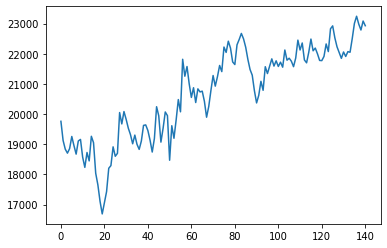

In [ ]:
a = pd.Series(profit)
a = a.cumsum()
a += 20000
a.plot()

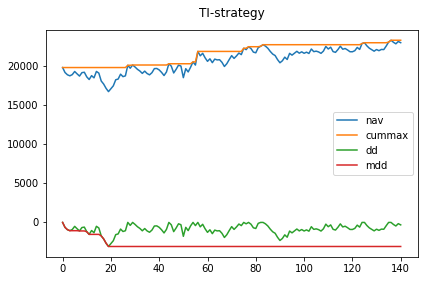

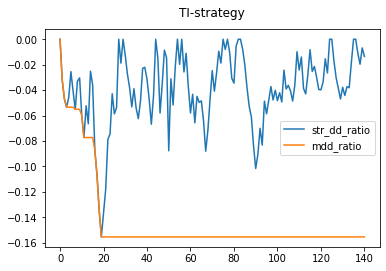

----------------------------------------
ti-strategy mdd= -0.1554246718010009


In [ ]:
import matplotlib.pyplot as plt
# 最大回撤
def get_mdd(nav): 
    mdd = 0.
    nav_max = nav.cummax() # 累積最大值
    drawdown = (nav - nav_max) / nav_max # 從上個波峰算每天的回撤比例
    mdd = drawdown.cummin() # drawdown是負值，取cummin找出最小的（絕對值最大）的回撤
    return mdd

daily_navs = a
daily_navs.plot()
nav_max = daily_navs.cummax()
nav_max.plot()
dd = daily_navs-nav_max
dd.plot()
mdd = dd.cummin()
mdd.plot()
plt.title("TI-strategy", x=0.5, y=1.03)
plt.legend(['nav', 'cummax', 'dd', 'mdd'])

plt.tight_layout()
plt.show()

dd_ratio = dd/nav_max
dd_ratio.plot()
mdd_ratio = dd_ratio.cummin()
mdd_ratio.plot()
plt.legend(['str_dd_ratio', 'mdd_ratio'])
plt.title("TI-strategy", x=0.5, y=1.03)
plt.show()
print('-'*40)
print('ti-strategy mdd=', min(mdd_ratio))

### 比特幣這邊扣掉手續費後只有大概$3000的報酬 不是太好 嘗試看看ETH

In [ ]:
klines = client.get_historical_klines("ADAUSDT", Client.KLINE_INTERVAL_5MINUTE, "31 Aug, 2020", "31 Aug, 2021")

In [ ]:
# 2 parameters to be tuned: margin, pl_ratio
margin = 0.003 # to be tuned 
pl_ratio = 2 # to be tuned 

price = price_preprocessing(klines)
price = adjust_price_date(price,'2020-08-31 08:00:00')
price = PricesStringToInt(price)
price['ema25'] = talib.EMA(price['close'], timeperiod=25)
price['ema50'] = talib.EMA(price['close'], timeperiod=50)
price['ema100'] = talib.EMA(price['close'], timeperiod=100)

price = price.dropna() # 把沒有技術指標的移除

buy_orders, sell_orders = [], []

ma_interval = margin * price.iloc[0]['close']

# for index,value in price.iterrows():
ema_ASEC1 = (price['ema25'] - price['ema50'])  > ma_interval
ema_ASEC2 = (price['ema50'] - price['ema100'])  > ma_interval
ema_DSEC1 = (price['ema25'] - price['ema50'])  < (-1 * ma_interval)
ema_DSEC2 = (price['ema50'] - price['ema100'])  < (-1 * ma_interval)

price['trend'] = 0

price.loc[ema_ASEC1 & ema_ASEC2,'trend'] = 1
price.loc[ema_DSEC1 & ema_DSEC2,'trend'] = -1 


activate_long,activate_short = False,False
buy_orders, sell_orders = [], []
buy, sell = False, False
can_trade = True
last_trade_trend = 0


def create_orders(side,price,index_time,sl,tp):
    if side == 'buy':
        buy_orders.append({'side':side,'price':price,'time':index_time,'sl':sl,'tp':tp})
    elif side == 'sell':
        sell_orders.append({'side':side,'price':price,'time':index_time,'sl':sl,'tp':tp})

    
# 處理 can_trade, 一個波段就是做一次交易

for index,value in price.iterrows():
    
    if buy:
        create_orders('buy',value['open'],index,value['ema50'],value['open']+(value['open']-value['ema50'])*pl_ratio) 
        buy = False 
        activate_long = False
        print('buy',value['open'],index)
        last_trade_trend = value['trend'] # 紀錄這個波段的趨勢屬性
        continue 
    if sell:
        create_orders('sell',value['open'],index,value['ema50'],value['open']-(value['ema50']-value['open'])*pl_ratio)
        sell = False
        activate_short = False
        print('sell',value['open'],index)
        last_trade_trend = value['trend'] # 紀錄這個波段的趨勢屬性
        continue 

    if activate_long: 
        if value['low'] < value['ema100']: # 跌破ema100, 上升趨勢已經消失，不做這個波段
            activate_long = False
        elif value['high'] > value['ema25']:  # 維持在ema50以上, 直接做多
            buy = True 
            activate_long = False
        continue
    elif activate_short:
        if value['high'] > value['ema100']: # 漲破ema100, 下降趨勢已經消失，不做這個波段
            activate_sell = False
        elif value['low'] < value['ema25']:  # 維持在ema50以下, 直接做空
            sell = True 
            activate_sell = False
        continue        

    if last_trade_trend != value['trend']: # 上次交易的波動和這次不同 才檢視ema, 預設為0所以1,-1都會觸發
        if value['trend'] == 1: # 上升趨勢
            if value['ema25'] >= value['low'] > value['ema100']: # 不能跌破ema100
                activate_long = True
                # print(cnt,index,'回調中，觸發主動做多條件')
                #cnt += 1
        
        elif value['trend'] == -1:
            if value['ema100'] > value['high'] >= value['ema25']: # 不能漲破ema100
                activate_short = True 
                # print(cnt,index,'回調中，觸發主動做空條件')
        else: # trend == 0 沒有明顯趨勢
            activate_long, activate_short = False, False 
    

sell 0.11409 2020-08-31 16:45:00
buy 0.12427 2020-09-01 05:15:00
sell 0.12215 2020-09-01 22:50:00
buy 0.12426 2020-09-02 03:45:00
sell 0.12134 2020-09-02 17:20:00
buy 0.10128 2020-09-04 19:10:00
sell 0.09885 2020-09-05 01:25:00
buy 0.10216 2020-09-05 06:10:00
sell 0.09667 2020-09-05 18:55:00
buy 0.09232 2020-09-06 18:50:00
sell 0.08956 2020-09-07 15:20:00
buy 0.09067 2020-09-08 03:45:00
buy 0.09148 2020-09-08 06:00:00
sell 0.09061 2020-09-08 20:40:00
buy 0.0924 2020-09-09 18:25:00
sell 0.09574 2020-09-11 11:30:00
buy 0.09788 2020-09-13 04:15:00
sell 0.09439 2020-09-13 23:30:00
buy 0.09688 2020-09-15 00:20:00
sell 0.09485 2020-09-16 00:45:00
buy 0.09278 2020-09-17 10:40:00
buy 0.09407 2020-09-18 06:50:00
sell 0.0911 2020-09-19 02:45:00
buy 0.07901 2020-09-24 20:50:00
sell 0.09412 2020-09-26 23:05:00
buy 0.09703 2020-09-27 10:35:00
sell 0.1008 2020-09-29 09:10:00
buy 0.10096 2020-10-01 00:45:00
sell 0.09696 2020-10-02 02:20:00
buy 0.09508 2020-10-04 22:55:00
sell 0.09488 2020-10-06 20:40

空單止損,利潤: -0.0009446454740845156
累積報酬: -0.001059207796821558
多單止損,利潤: -0.0006414660142592954
累積報酬: -0.0018246230780737237
空單止損,利潤: -0.0002674548488287992
累積報酬: -0.0022143616543269374
多單止損,利潤: -0.0003368994565509653
累積報酬: -0.0026753526611496274
空單止盈,利潤: 0.0017322446261248403
累積報酬: -0.0010635819127117246
多單止損,利潤: -0.0012934146570035276
累積報酬: -0.002457629862386751
空單止損,利潤: -9.749787562472745e-05
累積報酬: -0.0026540264869492907
多單止盈,利潤: 0.0010878845608695564
累積報酬: -0.001668845868360169
空單止盈,利潤: 0.0025640034399541933
累積報酬: 0.0007997695733140012
多單止盈,利潤: 0.0017363476060877625
累積報酬: 0.0024429290055987198
空單止損,利潤: -0.0007892079904394805
累積報酬: 0.0015637664111640194
多單止損,利潤: -0.00012025103884086286
累積報酬: 0.001352905497842577
多單止盈,利潤: 0.0006479127597335821
累積報酬: 0.0019090143011962924
空單止損,利潤: -0.001189588722020657
累積報酬: 0.0006282207848146253
多單止盈,利潤: 0.0009871469459948878
累積報酬: 0.0015224741573365156
空單止盈,利潤: 0.0008708865780212849
累積報酬: 0.002298056178646811
多單止損,利潤: -0.0007543149646943303
累積報酬: 0.0014

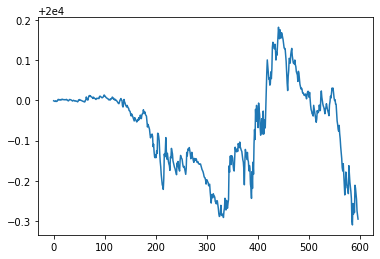

In [ ]:
profit, win_rate = get_profit(buy_orders,sell_orders,price)
a = pd.Series(profit)
a = a.cumsum()
a += 20000
a.plot()